# Simplex Algorithm — Complete Course (Beginner → Advanced)

This notebook is a complete, practice-heavy course on the **Simplex Algorithm** for **Linear Programming (LP)**.

## How to use this notebook

- Read the **short** concept bullets.
- Spend most of your time on:
  - **Worked examples** (simple → medium → advanced)
  - **Exercises** (easy/medium/challenging)
  - **Mini-projects** at the end of each chapter
- For many exercises you’ll see **Hints** and **Guided Solutions**. Try first, then open the solution.

## Learning outcomes

By the end you will be able to:

- Convert real problems into LPs in **standard form**.
- Run the **tableau simplex** method by hand and in Python.
- Diagnose and handle: **degeneracy**, **cycling**, **unboundedness**, **infeasibility**.
- Use **Two-Phase Simplex** and interpret **dual variables / shadow prices**.
- Understand (and lightly implement) the **revised simplex** viewpoint.

## Prerequisites

- Algebra (matrices/vectors)
- Basic Python (NumPy)

---

> Notation (default): we solve **maximization** LPs.
>
> $$\max\; c^T x \quad \text{s.t.}\quad Ax \le b,\; x\ge 0$$


In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 80)


def _as_float_array(x):
    return np.array(x, dtype=float)


def print_versions():
    import sys
    print("Python:", sys.version.split()[0])
    print("NumPy:", np.__version__)
    print("pandas:", pd.__version__)


print_versions()


Python: 3.13.11
NumPy: 2.3.5
pandas: 2.3.3


## Manim integration (rendering animations inside this course)

This notebook now includes **Manim-ready visualizations** to animate geometric and algorithmic ideas.

### Rendering workflow (recommended)

- We keep Manim scenes in a shared module: `../manim/simplex_course_scenes.py`
- Render a scene from a notebook cell using:
  - `!manim -pql ../manim/simplex_course_scenes.py SceneName`

### Why this helps

Manim is used here to make:

- **Geometry** (feasible region, vertices, objective level sets)
- **Dynamics** (pivot moves along edges)
- **Process** (tableau pivot and Two-Phase concept)
  visually concrete.

> If you render from a different working directory, adjust the path accordingly.


In [2]:
import os
import subprocess
from pathlib import Path
from IPython.display import Video


def manim_scene_path():
    # Notebook is in Math/, scenes live in ../manim/
    return os.path.join("..", "manim", "simplex_course_scenes.py")


def _find_latest_render(scene_name: str) -> Path:
    """Find the most recently rendered mp4 for a scene under ./media/videos."""
    root = Path("media") / "videos"
    if not root.exists():
        raise FileNotFoundError("No ./media/videos directory found. Did Manim render successfully?")

    matches = list(root.rglob(f"{scene_name}.mp4"))
    if not matches:
        raise FileNotFoundError(f"Rendered video for scene '{scene_name}' not found under {root}.")

    return max(matches, key=lambda p: p.stat().st_mtime)


def render_manim(scene_name, quality="l", *, width=None, height=None):
    """Render a Manim scene and display it inline in the notebook.

    quality:
      "l"  -> low  (-pql)
      "h"  -> high (-pqh)
    """
    scene_file = manim_scene_path()
    flag = "-pql" if quality == "l" else "-pqh"
    cmd = ["manim", flag, scene_file, scene_name]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)

    video_path = _find_latest_render(scene_name)
    print("Rendered video:", video_path)
    return Video(str(video_path), embed=True, width=width, height=height)


# Quick sanity check
print("Manim scenes file:", manim_scene_path())
print("Tip: render_manim('FeasibleRegionExampleA')  # shows video inline")

Manim scenes file: ../manim/simplex_course_scenes.py
Tip: render_manim('FeasibleRegionExampleA')  # shows video inline


# Chapter 1 — Linear Programming (LP) Foundations

## 1.1 What is an LP? (and why Simplex works)

### Core definitions (keep these _sharp_)

- **Decision variables**: unknowns you control (vector $x\in\mathbb{R}^n$).
- **Objective**: linear function to maximize/minimize: $c^T x$.
- **Constraints**: linear equalities/inequalities restricting feasible solutions.
- **Feasible region**: set of all $x$ satisfying constraints.
- **Vertex / extreme point**: “corner” of the feasible polytope.
- **Optimal solution**: feasible $x^*$ achieving best objective value.

### Key geometric fact (the engine behind Simplex)

If an LP has an optimal solution and the feasible region is a nonempty polytope, then **at least one optimal solution occurs at a vertex**.

So the game becomes:

- Find a _vertex_ (a basic feasible solution).
- Move from vertex to adjacent vertex improving the objective.
- Stop when no improving move exists.

---

## 1.2 Standard form, slack variables, and BFS

### Standard form (maximization)

A very common algorithm-friendly form is:

$$\max\; c^T x \quad \text{s.t.}\quad Ax = b,\; x\ge 0$$

Most problems start as $Ax\le b$ constraints. We convert them:

- For each “$\le$” constraint: add a **slack variable** $s\ge 0$ so $a_i^T x + s_i = b_i$.

### Basic solution and Basic Feasible Solution (BFS)

Given $Ax=b$ with $m$ equations and $n$ variables:

- Choose $m$ variables as **basic** (form a basis matrix $B$).
- Set the remaining $(n-m)$ **nonbasic** variables to 0.
- Solve $Bx_B=b$.
  This is a key concept to highlight. Here's content that explains basic vs. non-basic variables with concrete examples:

---

**This is called a basic solution.** If all entries of $x$ are nonnegative, the solution is feasible; otherwise it is infeasible.

#### Illustration: Basic vs. non-basic variables

From Example A with 4 variables and 2 equality constraints:

| Basis choice | Basic vars                                                          | Nonbasic vars (set to 0) | Solution           | Feasible? |
| ------------ | ------------------------------------------------------------------- | ------------------------ | ------------------ | --------- |
| $(x_1, x_2)$ | $x_1=4, x_2=0$ (from $x_1+0+s_1=4, 2x_1+0+s_2=5$ → $s_1=0, s_2=-3$) | $(s_1, s_2)$             | $(4, 0, 0, -3)$    | ✗         |
| $(s_1, s_2)$ | $s_1=4, s_2=5$                                                      | $(x_1, x_2)=(0,0)$       | $(0, 0, 4, 5)$     | ✓ BFS     |
| $(x_1, s_1)$ | Solve: $x_1 + s_1 = 4, 2x_1 = 5$ → $x_1=2.5, s_1=1.5$               | $(x_2, s_2)$             | $(2.5, 0, 1.5, 0)$ | ✓ BFS     |
| $(x_2, s_2)$ | Solve: $x_2 + s_1 = 4, x_2 + s_2 = 5$ → $x_2=4, s_2=1$              | $(x_1, s_1)$             | $(0, 4, 0, 1)$     | ✓ BFS     |

**Key insight:** Not every basis choice yields a feasible solution, but each **BFS is a vertex** of the feasible polytope.
If the resulting $x\ge 0$, it’s a **basic feasible solution** (a vertex candidate).

---

## 1.3 Worked examples (simple → medium → advanced)

### Example A (simple): Convert to standard form

Maximize $z = 3x_1 + 2x_2$ subject to

- $x_1 + x_2 \le 4$
- $2x_1 + x_2 \le 5$
- $x_1, x_2 \ge 0$

**Standard form** (add slacks $s_1,s_2\ge 0$):

- $x_1 + x_2 + s_1 = 4$
- $2x_1 + x_2 + s_2 = 5$

### Example B (medium): Identify BFS by inspection

From Example A, a BFS corresponds to selecting 2 basic variables among $(x_1,x_2,s_1,s_2)$ and setting the other 2 to zero.

Try bases like $(s_1,s_2)$, $(x_1,s_2)$, $(x_2,s_1)$, etc.

### Example C (advanced): Modeling (production planning)

A factory makes products A and B.

- Profit: $40$ per A, $30$ per B.
- Machine hours: A uses 2, B uses 1; capacity 100.
- Labor: A uses 1, B uses 1; capacity 80.

**LP**:
$$\max 40A + 30B\;\;\text{s.t.}\;\;2A + B \le 100,\; A + B \le 80,\; A,B\ge 0.$$

---

## 1.4 Practical applications (why you should care)

- **Operations**: production planning, cutting stock approximations, blending.
- **Logistics**: routing, scheduling, staffing, inventory.
- **Finance**: portfolio constraints, risk budgeting (linear approximations).
- **ML**: SVM duals, L1-regularized problems (often reducible to LP).

---

## 1.5 Common mistakes & misconceptions

- “Simplex searches all points.” → It searches **vertices**, not the interior.
- “Any feasible point is a BFS.” → BFS is special: it comes from a **basis**.
- Forgetting **nonnegativity** after transforming variables (e.g., free variables require substitution).
- Mixing sign conventions for maximization/minimization.

---

## 1.6 Exercises (with hints/solutions)

### Exercises — Easy

1. Convert to standard form:
   $$\min\; 5x_1 - x_2\;\;\text{s.t.}\;\;x_1 - 2x_2 \le 3,\; x_1\ge 0,\; x_2 \text{ free}. $$
2. For Example A, list at least **three** candidate bases and compute the corresponding basic solutions.

### Exercises — Medium

3. Model a diet problem with 2 foods and 2 nutrients (calories + protein). Write the LP.
4. Show that if $b$ has a negative entry, the “all-slack” basis may be infeasible.

### Exercises — Challenging

5. Construct an LP with **multiple optimal solutions** and explain geometrically why.

<details>
<summary><strong>Hints</strong></summary>

- (1) If $x_2$ is free, write $x_2 = x_2^+ - x_2^-$ with $x_2^+,x_2^-\ge 0$.
- (2) Set nonbasic variables to 0, solve the two equations.
- (5) Try an objective parallel to an edge of the feasible polygon.

</details>

<details>
<summary><strong>Guided solutions (sketches)</strong></summary>

- (1) Convert min to max via negation if desired; handle free variable with $x_2^+,x_2^-$. Add slack for the $\le$.
- (5) Example: maximize $x_1$ subject to $x_1\le 1$, $0\le x_2\le 1$. Every point with $x_1=1$ is optimal.

</details>

---

## Chapter 1 summary

- LPs optimize a linear function over a polytope.
- If an optimum exists, there’s an optimum at a **vertex**.
- Converting to **standard form** and understanding **BFS** is the foundation for Simplex.

## Chapter 1 review questions

1. What exactly makes a solution “basic”?
2. Why do we introduce slack variables?
3. When can an LP have infinitely many optimal solutions?

## Chapter 1 mini-project

Model and solve (conceptually) a small real scenario from your life:

- Choose 2–4 decision variables (time allocation, budgeting, meal planning, etc.).
- Write objective + constraints.
- Convert to standard form.
- Identify at least two BFS candidates.


## Manim Visual Support — Chapter 1 (LP Foundations)

### Concepts that benefit from animation

- **Feasible region** as an intersection of half-spaces (build-up of constraints).
- **Vertices (BFS)** as “corners” that appear when constraints intersect.
- **Objective level sets** sliding until they “support” the feasible region at an optimal vertex.

### Intended animation (what appears, how it moves, what it demonstrates)

1. Axes appear.
2. Each constraint boundary line is drawn one-by-one.
3. The feasible polygon is shaded as the intersection.
4. Vertices are marked (visually reinforcing BFS).
5. An objective level line $c^T x = k$ slides in the direction of improvement until it becomes a supporting line.

### Manim scene (clean, reusable)

The shared scene `FeasibleRegionExampleA` renders exactly the above for Chapter 1 Example A.

### How this supports the learning objective

It makes the key theorem (“an optimum occurs at a vertex”) visually undeniable: the last feasible contact point of a moving supporting line is a corner.

### Student modifications / exercises (Manim)

- Change the coefficients in the scene to create:
  - multiple optima (level set aligns with an edge)
  - infeasible region (no intersection)
  - different optimal corners
- Add a third constraint and observe how a new edge/vertex is introduced.


In [3]:
# Render Chapter 1 geometry animation
# Low quality is fast; switch to quality="h" for high-quality.
render_manim("FeasibleRegionExampleA", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py FeasibleRegionExampleA
Manim Community v0.19.1

[12/18/25 09:07:18] INFO     Animation 0 : Using cached     ]8;id=163935;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=803969;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_537823710_223132457                     
                             )                                                  


                    INFO     Animation 1 : Using cached     ]8;id=834958;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=607702;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2003774714_19639768                     
                             76)                                                


                    INFO     Animation 2 : Using cached     ]8;id=161257;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=519621;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1298191237_27164532                     
                             21)                                                
                    INFO     Animation 3 : Using cached     ]8;id=258007;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=737396;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2205731581_35065163                 

[12/18/25 09:07:19] INFO     Animation 4 : Using cached     ]8;id=690068;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=958754;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3238489081_30936662                     
                             84)                                                


                    INFO     Animation 5 : Using cached     ]8;id=792830;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=857075;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3120122277_41203095                     
                             29)                                                


                    INFO     Animation 6 : Using cached     ]8;id=876448;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=845190;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2082935550_41203095                     
                             29)                                                


[12/18/25 09:07:20] INFO     Animation 7 : Using cached     ]8;id=334751;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=621989;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2821799979_41203095                     
                             29)                                                


                    INFO     Animation 8 : Using cached     ]8;id=465865;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=772677;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1839128356_11414640                     
                             38)                                                
                    INFO     Animation 9 : Using cached     ]8;id=604780;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=329374;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_385293145_273113283                 

[12/18/25 09:07:21] INFO     Animation 10 : Using cached    ]8;id=855190;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=291687;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_621391463_389664233                     
                             0)                                                 


[12/18/25 09:07:22] INFO     Animation 11 : Using cached    ]8;id=57468;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=187392;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_12612971                     
                             48)                                                
                    INFO     Combining to Movie file.   ]8;id=738974;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=916204;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=183562;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\

In [4]:
import itertools
import matplotlib.pyplot as plt


def enumerate_bfs(A, b, var_names=None, tol=1e-9):
    """Enumerate BFS for small problems Ax=b, x>=0 by trying all bases.

    A: (m,n), b: (m,)
    Returns list of dicts with basis indices, solution x, and feasibility.
    """
    A = _as_float_array(A)
    b = _as_float_array(b)
    m, n = A.shape
    if var_names is None:
        var_names = [f"x{j+1}" for j in range(n)]

    results = []
    for basis in itertools.combinations(range(n), m):
        B = A[:, basis]
        if abs(np.linalg.det(B)) < tol:
            continue
        x = np.zeros(n)
        xB = np.linalg.solve(B, b)
        x[list(basis)] = xB
        feasible = np.all(x >= -1e-8)
        results.append({
            "basis": basis,
            "basis_vars": [var_names[j] for j in basis],
            "x": x,
            "feasible": feasible,
        })
    return results


# Example A from Chapter 1
# max 3x1+2x2
# s.t. x1+x2+s1=4, 2x1+x2+s2=5
A = np.array([
    [1, 1, 1, 0],
    [2, 1, 0, 1],
], dtype=float)
b = np.array([4, 5], dtype=float)
var_names = ["x1", "x2", "s1", "s2"]

bfs = enumerate_bfs(A, b, var_names=var_names)
rows = []
for r in bfs:
    x = r["x"]
    z = 3*x[0] + 2*x[1]
    rows.append({
        "basis": tuple(r["basis_vars"]),
        "x1": x[0],
        "x2": x[1],
        "s1": x[2],
        "s2": x[3],
        "feasible": r["feasible"],
        "objective_z": z,
    })

pd.DataFrame(rows).sort_values(["feasible", "objective_z"], ascending=[False, False]).reset_index(drop=True)


,basis,x1,x2,s1,s2,feasible,objective_z
0,"(x1, x2)",1.0,3.0,0.0,0.0,True,9.0
1,"(x2, s2)",0.0,4.0,0.0,1.0,True,8.0
2,"(x1, s1)",2.5,0.0,1.5,0.0,True,7.5
3,"(s1, s2)",0.0,0.0,4.0,5.0,True,0.0
4,"(x1, s2)",4.0,0.0,0.0,-3.0,False,12.0
5,"(x2, s1)",0.0,5.0,-1.0,0.0,False,10.0


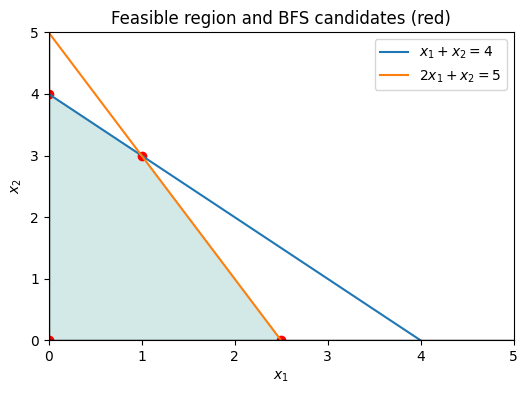

In [5]:
# Visualize feasible region for Example A in (x1,x2)

x1 = np.linspace(0, 5, 400)
x2_line1 = 4 - x1
x2_line2 = 5 - 2*x1

plt.figure(figsize=(6, 4))
plt.plot(x1, x2_line1, label=r"$x_1+x_2=4$")
plt.plot(x1, x2_line2, label=r"$2x_1+x_2=5$")
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

# feasible region shading
x1_grid = np.linspace(0, 5, 501)
x2_grid = np.linspace(0, 5, 501)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
mask = (X1 + X2 <= 4 + 1e-9) & (2*X1 + X2 <= 5 + 1e-9) & (X1 >= 0) & (X2 >= 0)
plt.contourf(X1, X2, mask.astype(float), levels=[0.5, 1.5], alpha=0.2)

# plot feasible BFS points
for r in bfs:
    x = r["x"]
    if r["feasible"]:
        plt.scatter(x[0], x[1], color="red")

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Feasible region and BFS candidates (red)")
plt.legend()
plt.show()


# Chapter 2 — Geometry of Simplex + The Tableau Language

## 2.1 Adjacent vertices, edges, and “pivot moves”

### The picture you should have

- Feasible region is a polytope.
- **Vertices** correspond to **BFS**.
- Two BFS are **adjacent** if their bases differ by exactly one variable.

### Simplex move

A simplex step:

1. Choose a **nonbasic** variable to enter the basis (entering variable).
2. Increase it from 0 to improve the objective.
3. Some **basic** variable hits 0 first → it leaves the basis (leaving variable).

That “swap” is a **pivot**.

---

## 2.2 Why objective improvement is “local” but still works

For many optimization problems, local improvement can get stuck. LP is special:

- Objective is linear.
- Feasible set is convex polytope.
- If a vertex is not optimal, there exists an adjacent edge that increases the objective.

Simplex exploits this structure.

---

## 2.3 The simplex tableau (a computation-friendly view)

### Tableau idea

You rewrite the constraints to express current **basic variables** as functions of **nonbasic variables**.

A typical tableau (max form) stores:

- Coefficients of constraints
- Right-hand side (RHS)
- Objective row

### Reduced costs (most important tableau concept)

- In the objective row, coefficients of nonbasic variables tell you how much the objective improves per unit increase.
- For maximization: a **negative** reduced cost (depending on sign convention) indicates an improving direction.

---

## 2.4 Worked examples (simple → medium → advanced)

### Example A (simple): Build a tableau for Chapter 1 Example A

Start with the slack basis $(s_1,s_2)$.

### Example B (medium): One full pivot by hand

- Pick entering variable by the most improving reduced cost.
- Use the **minimum ratio test** to pick leaving variable.
- Perform the pivot row operations.

### Example C (advanced): Interpreting the tableau as a system

Read the tableau as:

- Basic variables = RHS − (coeffs)·(nonbasic variables)
- Objective = constant + (coeffs)·(nonbasic variables)

---

## 2.5 Common mistakes & misconceptions

- Confusing “entering variable” with “largest coefficient in $c$”. Entering depends on **reduced costs**, not raw $c$.
- Doing ratio test with negative/zero pivot column entries (invalid).
- Forgetting that a pivot changes the _meaning_ of each row’s equation.

---

## 2.6 Exercises

### Exercises — Easy

1. For a 2D feasible polygon, explain what it means for two vertices to be adjacent.
2. In a tableau step, why must the pivot column entry be **positive** in the leaving row?

### Exercises — Medium

3. For Example A, compute the first entering variable using reduced costs (using the standard tableau sign convention used later in code).
4. Do one pivot by hand and verify feasibility.

### Exercises — Challenging

5. Construct a case where there are multiple valid entering variables. What does that mean geometrically?

<details>
<summary><strong>Hints</strong></summary>

- (2) You need a positive step length to keep the leaving variable nonnegative.
- (5) If two edges from the same vertex both improve the objective, you have a “choice” of improving directions.

</details>

---

## Chapter 2 summary

- Simplex moves along edges between adjacent vertices.
- The tableau encodes the current basis and objective.
- Reduced costs and the ratio test drive the algorithm.

## Chapter 2 review questions

1. What is the pivot operation algebraically?
2. How does the ratio test preserve feasibility?
3. What do reduced costs represent?

## Chapter 2 mini-project

Take your LP from Chapter 1 mini-project and:

- Put it in standard form.
- Identify an initial basis (if possible).
- Write the initial tableau (symbolically is fine).


## Manim Visual Support — Chapter 2 (Geometry + Tableau Language)

### Concepts that benefit from animation

- **Adjacency**: why a pivot is an edge move between adjacent vertices.
- **Pivot move**: the “swap one basic variable” idea as a physical motion.
- **Tableau pivot mechanics**: identifying a pivot element and performing row operations.

### Intended animations

#### A) Pivot as a move on the polygon (geometry)

- Draw the feasible polygon.
- Highlight a starting vertex.
- Animate a dot traveling along one edge to an adjacent vertex.
- Label the move as “entering/leaving variable swap”.

#### B) Tableau pivot (schematic)

- Display a small tableau as a matrix.
- Animate the “before → after” pivot (schematic transform).
- Call out the key invariant visually: the entering column becomes a unit vector.

### How this supports the learning objective

It bridges the two mental models:

- **Geometry**: moving along edges.
- **Algebra**: row operations preserving the same feasible set description.

### Student modifications / Manim exercises

- Re-render the pivot move from a different start vertex.
- Replace the tableau numbers in the schematic with your own tableau (from a worked example) and animate the transformation.


In [6]:
# Render Chapter 2 animations
render_manim("PivotMoveOnPolygon", quality="l")
render_manim("TableauPivotSchematic", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py PivotMoveOnPolygon
Manim Community v0.19.1

[12/18/25 09:07:28] INFO     Animation 0 : Using cached     ]8;id=625048;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=342422;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_2071266577_22313245                     
                             7)                                                 


                    INFO     Animation 1 : Using cached     ]8;id=233822;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=680745;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2204422499_34553220                     
                             83)                                                
                    INFO     Animation 2 : Using cached     ]8;id=425346;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=482535;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2309335805_27983690                 

[12/18/25 09:07:31] INFO     Animation 6 : Partial      ]8;id=707936;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=118216;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#590\590]8;;\
                             movie file written in                              
                             '/home/shk/Documents/proje                         
                             cts/python/ML/DataCamp/Mat                         
                             h/media/videos/simplex_cou                         
                             rse_scenes/480p15/partial_                         
                             movie_files/PivotMoveOnPol                         
                             ygon/4072820271_1305021354                         
                             _3396564216.mp4'                                   
                    INFO     Animation 7 : Partial 

                    INFO     Animation 1 : Using cached     ]8;id=215691;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=548512;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2484485537_15444788                     
                             4)                                                 
                    INFO     Writing Choose pivot        ]8;id=889971;file:///home/shk/.local/lib/python3.13/site-packages/manim/utils/tex_file_writing.py\tex_file_writing.py]8;;\:]8;id=857205;file:///home/shk/.local/lib/python3.13/site-packages/manim/utils/tex_file_writing.py#111\111]8;;\
                             column/row $\to$ normalize                         
                             $\to$ eliminate to                              

[12/18/25 09:07:36] INFO     Animation 2 : Partial      ]8;id=423046;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=717338;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#590\590]8;;\
                             movie file written in                              
                             '/home/shk/Documents/proje                         
                             cts/python/ML/DataCamp/Mat                         
                             h/media/videos/simplex_cou                         
                             rse_scenes/480p15/partial_                         
                             movie_files/TableauPivotSc                         
                             hematic/4072820271_3433513                         
                             167_1368467677.mp4'                                


[12/18/25 09:07:38] INFO     Animation 3 : Partial      ]8;id=255055;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=86353;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#590\590]8;;\
                             movie file written in                              
                             '/home/shk/Documents/proje                         
                             cts/python/ML/DataCamp/Mat                         
                             h/media/videos/simplex_cou                         
                             rse_scenes/480p15/partial_                         
                             movie_files/TableauPivotSc                         
                             hematic/4072820271_2963960                         
                             227_2829885243.mp4'                                


[12/18/25 09:07:40] INFO     Animation 4 : Partial      ]8;id=759442;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=467094;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#590\590]8;;\
                             movie file written in                              
                             '/home/shk/Documents/proje                         
                             cts/python/ML/DataCamp/Mat                         
                             h/media/videos/simplex_cou                         
                             rse_scenes/480p15/partial_                         
                             movie_files/TableauPivotSc                         
                             hematic/4072820271_3120513                         
                             394_3157174421.mp4'                                
[12/18/25 09:07:41] INFO     Animation 5 : Partial 

In [7]:
def make_tableau_max_leq(A, b, c, var_names=None):
    """Create initial simplex tableau for max c^T x s.t. Ax<=b, x>=0.

    Adds slack variables s>=0, assumes b>=0.
    Tableau format:
      rows 0..m-1: constraints
      last row: objective (reduced cost row) with -c for original variables
      last column: RHS

    We use the convention:
    - Choose entering variable as the most negative coefficient in the last row.
    - Optimal when all last-row coefficients >= 0.
    """
    A = _as_float_array(A)
    b = _as_float_array(b)
    c = _as_float_array(c)

    m, n = A.shape
    if var_names is None:
        var_names = [f"x{j+1}" for j in range(n)]

    slack_names = [f"s{i+1}" for i in range(m)]
    names = var_names + slack_names

    tableau = np.zeros((m + 1, n + m + 1), dtype=float)
    tableau[:m, :n] = A
    tableau[:m, n:n + m] = np.eye(m)
    tableau[:m, -1] = b

    tableau[-1, :n] = -c
    tableau[-1, -1] = 0.0

    basis = list(range(n, n + m))  # slacks initially
    return tableau, basis, names


def tableau_to_df(tableau, basis, names):
    m_plus_1, total_plus_rhs = tableau.shape
    total = total_plus_rhs - 1
    df = pd.DataFrame(tableau, columns=names + ["RHS"]) 
    row_names = [f"row{i+1}" for i in range(m_plus_1 - 1)] + ["obj"]
    df.index = row_names

    # annotate which variable is basic in each constraint row
    basic_vars = [names[j] for j in basis]
    df.insert(0, "basic", basic_vars + [""])
    return df


def pivot(tableau, basis, pivot_row, pivot_col, tol=1e-12):
    """Pivot on (pivot_row, pivot_col) in-place, update basis."""
    piv = tableau[pivot_row, pivot_col]
    if abs(piv) < tol:
        raise ValueError("Pivot element is (near) zero")

    tableau[pivot_row, :] = tableau[pivot_row, :] / piv

    m, n = tableau.shape
    for r in range(m):
        if r == pivot_row:
            continue
        factor = tableau[r, pivot_col]
        if abs(factor) > tol:
            tableau[r, :] -= factor * tableau[pivot_row, :]

    basis[pivot_row] = pivot_col


def choose_entering_variable(tableau, tol=1e-12):
    last_row = tableau[-1, :-1]
    # most negative coefficient
    min_val = np.min(last_row)
    if min_val >= -tol:
        return None
    return int(np.argmin(last_row))


def choose_leaving_variable(tableau, entering_col, tol=1e-12):
    m = tableau.shape[0] - 1
    col = tableau[:m, entering_col]
    rhs = tableau[:m, -1]

    ratios = []
    for i in range(m):
        if col[i] > tol:
            ratios.append((rhs[i] / col[i], i))
    if not ratios:
        return None

    # minimum ratio test
    ratios.sort(key=lambda x: (x[0], x[1]))
    return ratios[0][1]


def simplex_tableau_solve_max_leq(A, b, c, var_names=None, max_iters=100, bland=False, verbose=True):
    tableau, basis, names = make_tableau_max_leq(A, b, c, var_names=var_names)
    m = tableau.shape[0] - 1

    def choose_entering():
        last_row = tableau[-1, :-1]
        neg_cols = [j for j, v in enumerate(last_row) if v < -1e-12]
        if not neg_cols:
            return None
        return min(neg_cols) if bland else int(neg_cols[np.argmin(last_row[neg_cols])])

    history = []
    for it in range(max_iters):
        entering = choose_entering()
        if entering is None:
            status = "optimal"
            break

        leaving = choose_leaving_variable(tableau, entering)
        if leaving is None:
            status = "unbounded"
            break

        if verbose:
            history.append({
                "iter": it,
                "enter": names[entering],
                "leave": names[basis[leaving]],
            })
        pivot(tableau, basis, leaving, entering)
    else:
        status = "iteration_limit"

    # extract solution
    n_total = len(names)
    x = np.zeros(n_total)
    for i in range(m):
        x[basis[i]] = tableau[i, -1]

    z = tableau[-1, -1]
    return {
        "status": status,
        "tableau": tableau,
        "basis": basis,
        "names": names,
        "x": x,
        "objective": z,
        "history": history,
    }


# Build and display the initial tableau for Example A
A_leq = np.array([[1, 1], [2, 1]], dtype=float)
b_leq = np.array([4, 5], dtype=float)
c = np.array([3, 2], dtype=float)

res0 = simplex_tableau_solve_max_leq(A_leq, b_leq, c, var_names=["x1", "x2"], verbose=False)
tableau_to_df(res0["tableau"], res0["basis"], res0["names"]).round(4)


,basic,x1,x2,s1,s2,RHS
row1,x2,0.0,1.0,2.0,-1.0,3.0
row2,x1,1.0,0.0,-1.0,1.0,1.0
obj,,0.0,0.0,1.0,1.0,9.0


In [8]:
res = simplex_tableau_solve_max_leq(A_leq, b_leq, c, var_names=["x1", "x2"], verbose=True)
print("status:", res["status"])
print("history (pivot decisions):")
print(pd.DataFrame(res["history"]))

df_final = tableau_to_df(res["tableau"], res["basis"], res["names"]).round(4)
df_final


status: optimal
history (pivot decisions):
   iter enter leave
0     0    x1    s2
1     1    x2    s1


,basic,x1,x2,s1,s2,RHS
row1,x2,0.0,1.0,2.0,-1.0,3.0
row2,x1,1.0,0.0,-1.0,1.0,1.0
obj,,0.0,0.0,1.0,1.0,9.0


# Chapter 3 — The Simplex Algorithm (Tableau Form) Step-by-Step

## 3.1 The algorithm (tableau form) in one page

Assume:
$$\max\; c^T x \;\;\text{s.t.}\;\; Ax\le b,\; x\ge 0,\; b\ge 0$$

### Step 0 — Build initial tableau

- Add slacks $s$.
- Start with slack basis.

### Step 1 — Choose entering variable (improves objective)

Using our convention (objective row has $-c$ initially):

- If the objective row has a **negative** coefficient in column $j$, increasing variable $j$ can improve the objective.
- Choose one such column (often the _most negative_).

### Step 2 — Choose leaving variable (stay feasible)

- For the entering column $j$, compute ratios $\frac{b_i}{a_{ij}}$ for rows with $a_{ij}>0$.
- Smallest ratio determines the step before some basic variable hits 0.

### Step 3 — Pivot

- Perform row operations so the entering column becomes a unit vector.
- Update basis.

### Step 4 — Stop

- If no negative coefficient remains in objective row → **optimal**.
- If entering column has no positive entries → **unbounded**.

---

## 3.2 Worked examples (simple → medium → advanced)

### Example A (simple): reuse Example A (done above)

Focus on:

- Which variable enters first and why.
- How the ratio test picks the leaving variable.

### Example B (medium): 3 constraints, 2 variables

You will see more pivots and more opportunities to make mistakes.

### Example C (advanced): interpret final tableau

Given a final tableau, extract:

- primal optimal solution $x^*$
- objective value $z^*$
- which constraints are tight (binding)

---

## 3.3 Practical applications (how simplex shows up)

- “What should I produce?” → production planning.
- “How should I allocate resources?” → staffing, capacity.
- “What’s the marginal value of capacity?” → sensitivity (Chapter 5).

---

## 3.4 Common mistakes & how to avoid them

- **Wrong ratio test**: only use rows with positive pivot column.
- **Arithmetic drift**: track fractions carefully; in code, use floats + tolerances.
- **Stopping too early**: check objective row sign convention carefully.
- **Forgetting variable names**: always label columns.

---

## 3.5 Exercises (with hints/solutions)

### Exercises — Easy

1. Explain why the ratio test preserves $x\ge 0$.
2. In our convention, what does it mean if a coefficient in the objective row is negative?

### Exercises — Medium

3. Solve this LP by hand (at least 2 pivots):
   $$\max\; 5x_1 + 4x_2\;\;\text{s.t.}\;\; 6x_1 + 4x_2\le 24,\; x_1 + 2x_2\le 6,\; -x_1 + x_2\le 1,\; x\ge 0.$$

4. Use the Python simplex below to confirm your answer.

### Exercises — Challenging

5. Create an LP where the _most negative reduced cost rule_ takes more pivots than another pivot rule (you only need a small example). Explain the intuition.

<details>
<summary><strong>Hints</strong></summary>

- (3) Add 3 slacks; start with slack basis.
- (5) Pivot rules change the path through vertices; the set of vertices is finite but the path length can vary.

</details>

---

## Chapter 3 summary

- Simplex iterates: choose entering → ratio test → pivot.
- It terminates at an optimum when the objective row has no improving directions.
- Implementation is straightforward once tableau mechanics are clear.

## Chapter 3 review questions

1. What does “unbounded” look like in the tableau?
2. What is a pivot operation doing to the system of equations?
3. How do you read the primal solution from the tableau?

## Chapter 3 mini-project

Pick a small LP with 2–3 variables and 2–4 constraints.

- Solve it by hand (tableau pivots).
- Solve it in code.
- Compare intermediate tableaus.


## Manim Visual Support — Chapter 3 (Simplex Step-by-Step)

### Concepts that benefit from animation

- **Iteration as a process**: repeating “enter → ratio test → pivot”.
- **Unboundedness detection**: what it means geometrically vs what it looks like algorithmically.
- **Numerical pivot intuition**: why the pivot column becomes a unit column after row ops.

### Intended animations

#### A) Pivot move emphasis (repeated)

Re-render the pivot move (Chapter 2) as a deliberate “iteration step” with narration.

#### B) Tableau pivot schematic (repeated)

Use the tableau schematic as a _process visualization_:

- “Before” tableau
- pick pivot
- “After” tableau

### How this supports the learning objective

It reduces cognitive load: students can watch the algorithm as a repeated ritual, and then map each ritual step to the corresponding computations.

### Exercises / student modifications

- Replace the tableau numbers in `TableauPivotSchematic` with the actual tableau from your worked Example B and verify that your hand pivot matches the rendered “after” tableau.
- Create a new scene that overlays the **ratio test values** next to each constraint row.


In [9]:
# Render Chapter 3 process visualizations (re-using shared scenes)
render_manim("PivotMoveOnPolygon", quality="l")
render_manim("TableauPivotSchematic", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py PivotMoveOnPolygon
Manim Community v0.19.1

[12/18/25 09:07:45] INFO     Animation 0 : Using cached     ]8;id=537970;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=446888;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_2071266577_22313245                     
                             7)                                                 


                    INFO     Animation 1 : Using cached     ]8;id=772167;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=84871;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2204422499_34553220                     
                             83)                                                
                    INFO     Animation 2 : Using cached     ]8;id=220652;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=170108;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2309335805_27983690                  

[12/18/25 09:07:46] INFO     Animation 6 : Using cached     ]8;id=485407;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=636349;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1305021354_33965642                     
                             16)                                                


                    INFO     Animation 7 : Using cached     ]8;id=945589;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=164731;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_25677445                     
                             30)                                                
                    INFO     Combining to Movie file.   ]8;id=187269;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=842792;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=355789;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py

[12/18/25 09:07:50] INFO     Animation 1 : Using cached     ]8;id=411438;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=912731;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2484485537_15444788                     
                             4)                                                 


                    INFO     Animation 2 : Using cached     ]8;id=571167;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=223118;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3433513167_13684676                     
                             77)                                                


[12/18/25 09:07:51] INFO     Animation 3 : Using cached     ]8;id=70315;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=908585;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2963960227_28298852                     
                             43)                                                


[12/18/25 09:07:52] INFO     Animation 4 : Using cached     ]8;id=352629;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=806311;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3120513394_31571744                     
                             21)                                                


[12/18/25 09:07:53] INFO     Animation 5 : Using cached     ]8;id=971746;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=474979;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_23989490                     
                             11)                                                
                    INFO     Combining to Movie file.   ]8;id=704907;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=751572;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=957818;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py

In [10]:
# Worked Example (Chapter 3, Example B): a slightly larger LP
# max 5x1+4x2
# s.t. 6x1+4x2<=24
#      x1+2x2<=6
#     -x1+x2<=1
#      x>=0

A_ex = np.array([
    [6, 4],
    [1, 2],
    [-1, 1],
], dtype=float)
b_ex = np.array([24, 6, 1], dtype=float)
c_ex = np.array([5, 4], dtype=float)

res_ex = simplex_tableau_solve_max_leq(A_ex, b_ex, c_ex, var_names=["x1", "x2"], verbose=True)
print("status:", res_ex["status"], "objective:", res_ex["objective"])
print(pd.DataFrame(res_ex["history"]))

# Extract primal x1,x2
names = res_ex["names"]
x = res_ex["x"]
sol = {name: x[i] for i, name in enumerate(names)}
{k: round(sol[k], 6) for k in ["x1", "x2"]}, res_ex["objective"]


status: optimal objective: 21.0
   iter enter leave
0     0    x1    s1
1     1    x2    s2


({'x1': np.float64(3.0), 'x2': np.float64(1.5)}, np.float64(21.0))

# Chapter 4 — Special Cases + Two-Phase Simplex (Infeasible/Unbounded/Degenerate)

## 4.1 When the “easy start” fails

The slack-basis start works only when:

- all constraints are of type $\le$
- and $b\ge 0$

But real LPs often include:

- equality constraints ($=$)
- $\ge$ constraints
- negative right-hand sides

We need a systematic way to find a starting BFS.

---

## 4.2 Infeasibility vs unboundedness (do not confuse)

### Infeasible

No $x$ satisfies constraints.

- Two-phase Simplex detects this in **Phase I**.

### Unbounded

Feasible solutions exist, but objective can increase without limit.

- Detected by: entering column has **no positive** entries (no leaving variable).

---

## 4.3 Degeneracy and cycling

### Degeneracy

A BFS is **degenerate** if at least one basic variable is zero.

- Can cause **stalling**: objective doesn’t improve after a pivot.

### Cycling

In rare cases, naive pivot rules can loop forever.

### Bland’s rule (simple anti-cycling rule)

- Choose the entering variable with the **smallest index** among improving candidates.
- Choose the leaving variable with the **smallest index** among tied ratio-test candidates.

It guarantees termination.

---

## 4.4 Two-Phase Simplex (the standard fix)

### Phase I

Introduce **artificial variables** $a\ge 0$ to create an initial basis.
Minimize the sum of artificials:
$$\min \; \sum a_i$$
If the minimum is > 0 → the original LP is **infeasible**.

### Phase II

Drop artificial variables and optimize the original objective.

---

## 4.5 Exercises

### Easy

1. Give a simple example of an infeasible system of linear inequalities.
2. Give a simple example of an unbounded LP.

### Medium

3. Explain why degeneracy can cause the objective to stay the same after a pivot.
4. Implement Bland’s rule in a simplex solver (you’ll do this below).

### Challenging

5. Find (or construct) a small cycling example and test that Bland’s rule stops cycling.

---

## Chapter 4 summary

- Phase I distinguishes infeasible vs feasible.
- Unboundedness is detected via the leaving-variable failure.
- Degeneracy can cause stalling; Bland’s rule prevents cycling.

## Chapter 4 review questions

1. What does Phase I optimize and why?
2. How do you know an LP is infeasible from Phase I?
3. What exact tie-breaking does Bland’s rule impose?

## Chapter 4 mini-project

Take a real constraint set that includes at least one equality or $\ge$ constraint.

- Put it into a two-phase-ready form.
- Solve it with your two-phase implementation.
- Interpret feasibility and the final solution.


## Manim Visual Support — Chapter 4 (Special Cases + Two-Phase)

### Concepts that benefit from animation

- **Infeasible vs unbounded**: students often confuse these; geometry clarifies immediately.
- **Two-Phase simplex**: artificial variables are conceptually abstract without a visual “scaffolding” metaphor.
- **Degeneracy/cycling**: the idea of “moving but not improving” is easiest to understand dynamically.

### Intended animations

#### A) Infeasible vs unbounded (side-by-side)

- Two mini coordinate systems.
- Left: constraints that cannot overlap (visually: separated half-spaces) → “Infeasible”.
- Right: a feasible wedge plus an objective arrow pushing outward → “Unbounded”.

#### B) Two-Phase concept (scaffolding)

- Start with “no obvious BFS”.
- Introduce artificial variables as temporary supports.
- Animate Phase I driving the “sum of artificials” down to 0.
- Transition to Phase II (original objective).

### How this supports the learning objective

It builds the correct mental categories:

- Infeasible: **no feasible points exist**.
- Unbounded: **feasible points exist but objective can increase without limit**.
- Two-Phase: a principled method to _find_ a feasible starting basis.

### Student modifications / Manim exercises

- Modify the infeasible example so it becomes feasible (minimal change).
- Modify the unbounded example by adding one constraint to make it bounded.
- Extend the Two-Phase concept scene to show a concrete tiny LP (with explicit variables) and annotate which variables are artificial.


In [11]:
# Render Chapter 4 visualizations
render_manim("InfeasibleVsUnbounded2D", quality="l")
render_manim("TwoPhaseConcept", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py InfeasibleVsUnbounded2D
Manim Community v0.19.1

[12/18/25 09:07:57] INFO     Animation 0 : Using cached     ]8;id=391959;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=610891;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_3189827416_22313245                     
                             7)                                                 


                    INFO     Animation 1 : Using cached     ]8;id=131941;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=749187;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1521174745_25689022                     
                             44)                                                


[12/18/25 09:07:58] INFO     Animation 2 : Using cached     ]8;id=917072;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=307490;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_894345255_620300254                     
                             )                                                  


                    INFO     Animation 3 : Using cached     ]8;id=335877;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=956897;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3253267398_89598395                     
                             7)                                                 


                    INFO     Animation 4 : Using cached     ]8;id=655029;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=432001;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2533210769_20118975                     
                             0)                                                 


[12/18/25 09:07:59] INFO     Animation 5 : Using cached     ]8;id=833787;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=545880;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_452517225_213405820                     
                             3)                                                 


                    INFO     Animation 6 : Using cached     ]8;id=468418;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=945861;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2704448274_84990775                     
                             4)                                                 


[12/18/25 09:08:00] INFO     Animation 7 : Using cached     ]8;id=100338;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=764397;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_430427992_399985805                     
                             1)                                                 


                    INFO     Animation 8 : Using cached     ]8;id=218500;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=58832;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2016312030_10869812                     
                             82)                                                


                    INFO     Animation 9 : Using cached     ]8;id=139046;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=495579;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_4086096877_84691950                     
                             2)                                                 


[12/18/25 09:08:01] INFO     Animation 10 : Using cached    ]8;id=137075;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=675277;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2540907876_31780039                     
                             64)                                                


[12/18/25 09:08:02] INFO     Animation 11 : Using cached    ]8;id=210359;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=96368;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2201220123_36324808                     
                             99)                                                


[12/18/25 09:08:03] INFO     Animation 12 : Using cached    ]8;id=178561;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=32822;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_42357405                     
                             91)                                                
                    INFO     Combining to Movie file.   ]8;id=579234;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=884665;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=593651;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\

                    INFO     Animation 1 : Using cached     ]8;id=696686;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=159592;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_108111200_244999971                     
                             6)                                                 


[12/18/25 09:08:08] INFO     Animation 2 : Using cached     ]8;id=383555;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=926583;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1839128356_15725390                     
                             15)                                                
                    INFO     Animation 3 : Using cached     ]8;id=847391;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=957026;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_4261069753_20099632                 

[12/18/25 09:08:09] INFO     Animation 4 : Using cached     ]8;id=271909;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=422092;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1839128356_24307453                     
                             80)                                                
                    INFO     Animation 5 : Using cached     ]8;id=312196;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=359915;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2540567353_26787964                 

[12/18/25 09:08:10] INFO     Animation 6 : Using cached     ]8;id=738483;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=425672;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_484795728_320823505                     
                             2)                                                 


[12/18/25 09:08:11] INFO     Animation 7 : Using cached     ]8;id=514626;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=626199;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2786636948_15763307                     
                             08)                                                


                    INFO     Animation 8 : Using cached     ]8;id=764175;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=520080;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3694206531_15763307                     
                             08)                                                


[12/18/25 09:08:12] INFO     Animation 9 : Using cached     ]8;id=885051;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=400925;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3718770190_28412056                     
                             64)                                                


[12/18/25 09:08:13] INFO     Animation 10 : Using cached    ]8;id=123722;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=114184;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_72555997                     
                             3)                                                 
                    INFO     Combining to Movie file.   ]8;id=595967;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=89882;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=211828;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\

In [12]:
def make_tableau_from_equalities(Aeq, b, c, basis, names):
    """Create tableau for max c^T x s.t. Aeq x = b, x>=0 with a given initial basis.

    Tableau convention:
    - Objective row starts as -c.
    - Choose entering variable with negative objective-row coefficient.
    - Optimal when all objective-row coefficients >= 0.
    """
    Aeq = _as_float_array(Aeq)
    b = _as_float_array(b)
    c = _as_float_array(c)

    m, n = Aeq.shape
    tableau = np.zeros((m + 1, n + 1), dtype=float)
    tableau[:m, :n] = Aeq
    tableau[:m, -1] = b
    tableau[-1, :n] = -c

    # Canonicalize objective row w.r.t. current basis
    for i in range(m):
        bj = basis[i]
        coeff = tableau[-1, bj]
        if abs(coeff) > 1e-12:
            tableau[-1, :] -= coeff * tableau[i, :]

    return tableau


def simplex_tableau_solve(tableau, basis, names, max_iters=200, bland=False, tol=1e-12):
    """Simplex on a tableau already in equality form."""
    m = tableau.shape[0] - 1

    def choose_entering():
        last_row = tableau[-1, :-1]
        neg_cols = [j for j, v in enumerate(last_row) if v < -tol]
        if not neg_cols:
            return None
        return min(neg_cols) if bland else int(neg_cols[np.argmin(last_row[neg_cols])])

    history = []
    for it in range(max_iters):
        entering = choose_entering()
        if entering is None:
            return {"status": "optimal", "iters": it, "history": history}

        leaving = choose_leaving_variable(tableau, entering_col=entering, tol=tol)
        if leaving is None:
            return {"status": "unbounded", "iters": it, "history": history}

        history.append({
            "iter": it,
            "enter": names[entering],
            "leave": names[basis[leaving]],
        })
        pivot(tableau, basis, leaving, entering, tol=tol)

    return {"status": "iteration_limit", "iters": max_iters, "history": history}


def two_phase_simplex_max(A, b, c, senses, var_names=None, bland=True, tol=1e-9, verbose=True):
    """Two-Phase Simplex for max c^T x with mixed constraint senses.

    Problem:
      max c^T x
      s.t. A x (<=,=,>=) b
           x >= 0

    senses: list of strings in {"<=", "=", ">="}

    Returns a dict with status, solution, objective, tableau.
    """
    A = _as_float_array(A)
    b = _as_float_array(b)
    c = _as_float_array(c)

    m, n = A.shape
    senses = list(senses)
    if len(senses) != m:
        raise ValueError("len(senses) must equal number of rows of A")

    if var_names is None:
        var_names = [f"x{j+1}" for j in range(n)]

    # Preprocess: enforce b >= 0 by multiplying rows; flip inequality direction when needed
    A2 = A.copy()
    b2 = b.copy()
    senses2 = senses.copy()
    for i in range(m):
        if b2[i] < -tol:
            A2[i, :] *= -1
            b2[i] *= -1
            if senses2[i] == "<=":
                senses2[i] = ">="
            elif senses2[i] == ">=":
                senses2[i] = "<="
            # '=' stays '='

    # Build equality system by adding slack/surplus/artificial variables
    Aeq = A2.copy()
    names = var_names[:]

    slack_cols = []
    artificial_cols = []

    for i, s in enumerate(senses2):
        if s == "<=":
            col = np.zeros((m, 1))
            col[i, 0] = 1.0
            Aeq = np.hstack([Aeq, col])
            names.append(f"s{i+1}")
            slack_cols.append(Aeq.shape[1] - 1)
        elif s == ">=":
            # surplus
            col_sur = np.zeros((m, 1))
            col_sur[i, 0] = -1.0
            Aeq = np.hstack([Aeq, col_sur])
            names.append(f"u{i+1}")

            # artificial
            col_art = np.zeros((m, 1))
            col_art[i, 0] = 1.0
            Aeq = np.hstack([Aeq, col_art])
            names.append(f"a{i+1}")
            artificial_cols.append(Aeq.shape[1] - 1)
        elif s == "=":
            col_art = np.zeros((m, 1))
            col_art[i, 0] = 1.0
            Aeq = np.hstack([Aeq, col_art])
            names.append(f"a{i+1}")
            artificial_cols.append(Aeq.shape[1] - 1)
        else:
            raise ValueError(f"Unknown sense: {s}")

    n_total = Aeq.shape[1]

    # Initial basis: slack for <= rows, artificial for >= and = rows
    basis = [None] * m
    slack_iter = iter(slack_cols)
    for i, s in enumerate(senses2):
        if s == "<=":
            basis[i] = next(slack_iter)
        else:
            # Find the artificial variable that is 1 in row i
            found = None
            for j in artificial_cols:
                if abs(Aeq[i, j] - 1.0) < tol:
                    found = j
                    break
            if found is None:
                raise RuntimeError("Could not find an artificial basis column")
            basis[i] = found

    # Phase I: maximize -sum(artificials)
    c1 = np.zeros(n_total)
    for j in artificial_cols:
        c1[j] = -1.0

    tableau = make_tableau_from_equalities(Aeq, b2, c1, basis, names)
    if verbose:
        print("Phase I: maximize -sum(artificials)")

    out1 = simplex_tableau_solve(tableau, basis, names, bland=bland)
    if verbose:
        print("Phase I status:", out1["status"], "iters:", out1["iters"]) 

    phase1_obj = tableau[-1, -1]

    # If feasible, minimum sum artificials is 0 => maximum of -sum artificials is 0.
    if phase1_obj < -1e-7:
        return {
            "status": "infeasible",
            "phase1_objective": phase1_obj,
            "tableau": tableau,
            "basis": basis,
            "names": names,
            "phase1_history": out1["history"],
        }

    # Phase II objective: original c on original variables; all added vars have 0 cost
    c2 = np.zeros(n_total)
    c2[:n] = c

    tableau[-1, :] = 0.0
    tableau[-1, :-1] = -c2

    # Canonicalize objective row w.r.t. current basis
    for i in range(m):
        bj = basis[i]
        coeff = tableau[-1, bj]
        if abs(coeff) > 1e-12:
            tableau[-1, :] -= coeff * tableau[i, :]

    if verbose:
        print("Phase II: optimize original objective")

    out2 = simplex_tableau_solve(tableau, basis, names, bland=bland)
    if verbose:
        print("Phase II status:", out2["status"], "iters:", out2["iters"]) 

    x_full = np.zeros(n_total)
    for i in range(m):
        x_full[basis[i]] = tableau[i, -1]

    return {
        "status": out2["status"],
        "objective": tableau[-1, -1],
        "x": x_full[:n],
        "x_full": x_full,
        "tableau": tableau,
        "basis": basis,
        "names": names,
        "phase1_objective": phase1_obj,
        "phase1_history": out1["history"],
        "phase2_history": out2["history"],
    }


In [13]:
# Two-Phase demonstrations

# (1) Equality constraint example
A1 = np.array([[1, 1]], dtype=float)
b1 = np.array([1], dtype=float)
c1 = np.array([1, 1], dtype=float)
senses1 = ["="]

r1 = two_phase_simplex_max(A1, b1, c1, senses1, var_names=["x1", "x2"], verbose=True)
print("Equality example:")
print("status:", r1["status"], "objective:", r1.get("objective"))
print("x:", r1.get("x"))

# (2) Infeasible example: x1 >= 2 and x1 <= 1
A2 = np.array([[1], [1]], dtype=float)
b2 = np.array([2, 1], dtype=float)
c2 = np.array([1], dtype=float)
senses2 = [">=", "<="]

r2 = two_phase_simplex_max(A2, b2, c2, senses2, var_names=["x1"], verbose=False)
print("\nInfeasible example:")
print(r2["status"], "phase1_objective:", r2.get("phase1_objective"))

# (3) Unbounded example: max x1 + x2 s.t. x1 - x2 >= 0, x>=0
A3 = np.array([[1, -1]], dtype=float)
b3 = np.array([0], dtype=float)
c3 = np.array([1, 1], dtype=float)
senses3 = [">="]

r3 = two_phase_simplex_max(A3, b3, c3, senses3, var_names=["x1", "x2"], verbose=False)
print("\nUnbounded example:")
print("status:", r3["status"], "objective:", r3.get("objective"), "x:", r3.get("x"))


Phase I: maximize -sum(artificials)
Phase I status: optimal iters: 1
Phase II: optimize original objective
Phase II status: optimal iters: 0
Equality example:
status: optimal objective: 1.0
x: [1. 0.]

Infeasible example:
infeasible phase1_objective: -1.0

Unbounded example:
status: unbounded objective: 0.0 x: [0. 0.]


# Chapter 5 — Duality, Shadow Prices, and Sensitivity (Interpretation Power)

## 5.1 The dual problem (for max with $\le$ constraints)

Primal (P):
$$\max\; c^T x \;\;\text{s.t.}\;\; Ax\le b,\; x\ge 0$$

Dual (D):
$$\min\; b^T y \;\;\text{s.t.}\;\; A^T y \ge c,\; y\ge 0$$

### Why duality matters

- $y_i$ is the **shadow price** of constraint $i$:
  - roughly: how much the optimal objective improves if you increase $b_i$ by 1.

---

## 5.2 Complementary slackness (the diagnostic tool)

At optimum:

- If primal constraint $i$ is slack (not tight), then $y_i = 0$.
- If $y_i > 0$, then the corresponding primal constraint is tight.

---

## 5.3 Sensitivity analysis (what-if questions)

You can often answer:

- If capacity increases by $\Delta$, how does profit change?
- Which constraints are “worth expanding”?

Caution:

- Shadow prices are valid within a **range** (basis stays optimal).

---

## 5.4 Worked examples

- Extract dual prices from a solved tableau basis.
- Verify strong duality: $c^T x^* = b^T y^*$.

---

## 5.5 Common mistakes

- Treating shadow prices as globally valid for arbitrarily large changes in $b$.
- Confusing reduced cost with shadow price.

---

## 5.6 Exercises

### Easy

1. Write the dual of:
   $$\max\; 2x_1 + x_2\;\;\text{s.t.}\;\; x_1 + x_2\le 4,\; x_1\le 2,\; x\ge 0.$$

### Medium

2. For Example A, compute $y$ and interpret it.
3. Use complementary slackness to predict which constraints are binding.

### Challenging

4. Find an LP where one constraint has shadow price 0 but is tight (degeneracy-related subtlety). Explain.

---

## Chapter 5 summary

- Dual variables quantify marginal value of constraints.
- Complementary slackness links primal slacks to dual values.
- Sensitivity is basis-dependent; ranges matter.

## Chapter 5 review questions

1. What does $y_i$ represent economically?
2. When is $y_i$ guaranteed to be 0?
3. Why do shadow prices change when the optimal basis changes?

## Chapter 5 mini-project

Take the production-planning LP (Chapter 1 Example C) and:

- Solve it.
- Extract shadow prices.
- Decide which resource you would expand first, and justify.


## Manim Visual Support — Chapter 5 (Duality + Shadow Prices)

### Concepts that benefit from animation

- **Shadow price** as a _sensitivity_ to shifting a constraint boundary.
- **Strong duality** intuition: how “supporting” constraints determine optimum.

### Intended animation

- Draw the feasible polygon for a small 2D LP.
- Mark the optimal vertex.
- Shift one constraint outward by $\Delta b$.
- Visually emphasize that the feasible region expands and the optimum objective can increase.
- Label the relationship “shadow price $\approx \Delta z / \Delta b$” (within validity range).

### How this supports the learning objective

Students see that dual variables are not mystical algebra: they quantify _how valuable relaxing a constraint is_, locally.

### Student modifications / exercises

- Change which constraint is shifted and observe whether the optimum moves.
- Create a case where the shifted constraint is non-binding at optimum; verify visually that the optimum does not change (shadow price 0).
- Extend the scene to display the objective level set before/after shifting.


In [14]:
# Render Chapter 5 shadow-price visualization
render_manim("ShadowPriceShift", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py ShadowPriceShift
Manim Community v0.19.1

[12/18/25 09:08:17] INFO     Animation 0 : Using cached     ]8;id=296971;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=902910;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_616600992_223132457                     
                             )                                                  


[12/18/25 09:08:18] INFO     Animation 1 : Using cached     ]8;id=200534;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=718118;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_284829979_327582135                     
                             1)                                                 
                    INFO     Animation 2 : Using cached     ]8;id=466613;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=668478;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_438452170_380894385                 

Animation 4: FadeIn(MathTex('b_1 \\uparrow')):   0%|          | 0/1 [00:00<?, ?it/s]

                    INFO     Animation 4 : Using cached     ]8;id=162520;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=401060;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1621998772_37971329                     
                             87)                                                
                    INFO     Animation 5 : Using cached     ]8;id=389623;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=449696;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2475220841_29980744                 

[12/18/25 09:08:19] INFO     Animation 6 : Using cached     ]8;id=581967;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=994793;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2678429544_31793949                     
                             79)                                                


[12/18/25 09:08:20] INFO     Animation 7 : Using cached     ]8;id=981938;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=68243;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_16217893                     
                             93)                                                
                    INFO     Combining to Movie file.   ]8;id=485376;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=344241;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=439388;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\

In [15]:
def extract_dual_prices_max_leq(A, c, basis, tol=1e-12):
    """For max c^T x s.t. Ax<=b, x>=0, compute dual y from basis.

    Uses y from B^T y = c_B where B is basis columns of [A I].
    """
    A = _as_float_array(A)
    c = _as_float_array(c)
    m, n = A.shape
    Abar = np.hstack([A, np.eye(m)])
    cbar = np.concatenate([c, np.zeros(m)])

    B = Abar[:, basis]
    cB = cbar[basis]

    # Solve B^T y = cB
    y = np.linalg.solve(B.T, cB)
    return y


def reduced_costs_max_leq(A, c, y):
    A = _as_float_array(A)
    c = _as_float_array(c)
    m, n = A.shape
    Abar = np.hstack([A, np.eye(m)])
    cbar = np.concatenate([c, np.zeros(m)])

    # r = c - A^T y  (for all vars)
    r = cbar - Abar.T @ y
    return r


# Dual interpretation on Example A
resA = simplex_tableau_solve_max_leq(A_leq, b_leq, c, var_names=["x1", "x2"], verbose=False)

yA = extract_dual_prices_max_leq(A_leq, c, basis=resA["basis"])
rA = reduced_costs_max_leq(A_leq, c, yA)

print("Dual prices y (one per constraint):", np.round(yA, 6))
print("Check y>=0:", np.all(yA >= -1e-9))

# Strong duality check: c^T x == b^T y
xA = resA["x"][:2]
print("primal objective:", float(c @ xA))
print("dual objective:", float(b_leq @ yA))

# Reduced costs for variables [x1,x2,s1,s2]
print("reduced costs r (x then slacks):", np.round(rA, 6))


Dual prices y (one per constraint): [1. 1.]
Check y>=0: True
primal objective: 9.0
dual objective: 9.0
reduced costs r (x then slacks): [ 0.  0. -1. -1.]


# Chapter 6 — Revised Simplex (How Solvers Really Do It)

## 6.1 Why revise the simplex?

The tableau stores _everything_ and does lots of row operations.
For large problems, that’s inefficient.

Revised simplex focuses on what you actually need each step:

- the current **basis matrix** $B$
- solving linear systems with $B$ (instead of full tableau updates)

In practice, solvers use LU factorizations and sparse linear algebra.

---

## 6.2 Revised simplex step-by-step (max, $\le$, $b\ge 0$)

Let $A\in\mathbb{R}^{m\times n}$, slacks give $[A\; I]$.

Maintain:

- Basis indices $\mathcal{B}$ (size $m$)
- Nonbasis indices $\mathcal{N}$
- Basic solution: $x_B = B^{-1} b$
- Dual prices: $y^T = c_B^T B^{-1}$
- Reduced costs: $\bar c_j = c_j - y^T a_j$

Pivot rule (max): if some reduced cost $\bar c_j>0$, enter it.

---

## 6.3 Common mistakes

- Mixing reduced-cost sign conventions between tableau and revised form.
- Forgetting that $B^{-1}$ is never explicitly formed in serious solvers.

---

## 6.4 Exercises

### Easy

1. Explain the computational difference between tableau and revised simplex.

### Medium

2. For a given basis $B$, compute $x_B$ and $y$ for a small example.

### Challenging

3. Implement revised simplex for max with $\le$ constraints and compare iteration counts with tableau simplex.

---

## Chapter 6 summary

- Revised simplex uses basis solves ($B^{-1}$ times a vector) instead of full tableau pivoting.
- It’s the conceptual bridge to professional LP solvers.

## Chapter 6 mini-project

Take a medium LP (3–6 variables, 3–6 constraints) and:

- Solve with tableau simplex.
- Solve with revised simplex.
- Compare pivot history and runtimes.


## Manim Visual Support — Chapter 6 (Revised Simplex)

### Concepts that benefit from animation

- Revised simplex is _conceptually simple_ but abstract: it’s “just” repeated basis solves.
- The relationships
  - $B x_B = b$,
  - $B^T y = c_B$,
  - $\bar c = c - A^T y$
    are much easier to remember when shown as a flow.

### Intended animation

- Display the three equations.
- Animate arrows showing the computational dependency flow.
- End with a one-line takeaway: “each iteration solves a few linear systems; no full tableau”.

### How this supports the learning objective

Students stop thinking of revised simplex as a different algorithm and start seeing it as the _efficient implementation_ of the same simplex logic.

### Student modifications / exercises

- Replace the symbolic equations with the numeric $B$, $b$, and $c_B$ from one of your solved examples.
- Extend the scene to show how changing one basis index swaps a column in $B$.


In [16]:
# Render Chapter 6 revised-simplex schematic
render_manim("BasisSolveSchematic", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py BasisSolveSchematic
Manim Community v0.19.1

[12/18/25 09:08:23] INFO     Animation 0 : Using cached     ]8;id=818361;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=368322;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_187794476_223132457                     
                             )                                                  


                    INFO     Animation 1 : Using cached     ]8;id=61753;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=879775;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_881236505_932189098                     
                             )                                                  


[12/18/25 09:08:24] INFO     Animation 2 : Using cached     ]8;id=9835;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=803954;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1611081439_38860286                     
                             87)                                                


                    INFO     Animation 3 : Using cached     ]8;id=862956;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=14567;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_3111059280_29446577                     
                             7)                                                 


[12/18/25 09:08:25] INFO     Animation 4 : Using cached     ]8;id=545852;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=580942;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_22922510                     
                             45)                                                
                    INFO     Combining to Movie file.   ]8;id=189751;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=598506;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=866654;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py

In [17]:
def revised_simplex_max_leq(A, b, c, max_iters=200, tol=1e-9, bland=False, verbose=True):
    """Revised simplex for max c^T x s.t. Ax<=b, x>=0 with b>=0.

    Uses slack start basis.
    Returns dict with status, x (original vars), objective, basis history.
    """
    A = _as_float_array(A)
    b = _as_float_array(b)
    c = _as_float_array(c)

    m, n = A.shape
    Abar = np.hstack([A, np.eye(m)])
    cbar = np.concatenate([c, np.zeros(m)])

    basis = list(range(n, n + m))
    nonbasis = list(range(n))

    history = []

    for it in range(max_iters):
        B = Abar[:, basis]
        xB = np.linalg.solve(B, b)

        if np.any(xB < -1e-8):
            return {"status": "numerical_issue", "basis": basis, "history": history}

        cB = cbar[basis]
        # y^T = cB^T B^{-1} => solve B^T y = cB
        y = np.linalg.solve(B.T, cB)

        # reduced costs for all variables
        r = cbar - Abar.T @ y

        # candidate entering: positive reduced cost for maximization
        candidates = [j for j in range(n + m) if j not in basis and r[j] > tol]
        if not candidates:
            # optimal
            x_full = np.zeros(n + m)
            for i in range(m):
                x_full[basis[i]] = xB[i]
            return {
                "status": "optimal",
                "x": x_full[:n],
                "objective": float(c @ x_full[:n]),
                "basis": basis,
                "history": history,
                "y": y,
                "reduced_costs": r,
            }

        entering = min(candidates) if bland else max(candidates, key=lambda j: r[j])

        a_enter = Abar[:, entering]
        d = np.linalg.solve(B, a_enter)

        # ratio test
        ratios = [(xB[i] / d[i], i) for i in range(m) if d[i] > tol]
        if not ratios:
            return {"status": "unbounded", "basis": basis, "history": history}

        ratios.sort(key=lambda x: (x[0], x[1]))
        theta, leave_row = ratios[0]
        leaving = basis[leave_row]

        history.append({
            "iter": it,
            "enter_idx": entering,
            "leave_idx": leaving,
            "theta": float(theta),
            "reduced_cost_enter": float(r[entering]),
        })

        basis[leave_row] = entering

    return {"status": "iteration_limit", "basis": basis, "history": history}


# Compare tableau vs revised on Example B
rev = revised_simplex_max_leq(A_ex, b_ex, c_ex, verbose=False)
print("revised status:", rev["status"], "objective:", rev.get("objective"), "x:", rev.get("x"))
print("tableau objective:", res_ex.get("objective"))
print("revised pivots:", len(rev.get("history", [])), "| tableau pivots:", len(res_ex.get("history", [])))


revised status: optimal objective: 21.0 x: [3.  1.5]
tableau objective: 21.0
revised pivots: 2 | tableau pivots: 2


# Chapter 7 — Applications & Case Studies (Model → Solve → Interpret)

This chapter is deliberately hands-on: you will model, solve, and interpret.

## 7.1 Modeling checklist (use this every time)

1. **Define variables** (units, domains).
2. **Objective** (what is being optimized, in what units?).
3. **Constraints** (resource limits, balances, requirements).
4. **Nonnegativity / bounds**.
5. Convert to **standard form** (when solving by simplex).
6. Sanity-check with edge cases.

---

## 7.2 Case study A: production planning (classic)

Products A and B:

- Profit: 40 per A, 30 per B
- Machine hours: 2 per A, 1 per B (capacity 100)
- Labor hours: 1 per A, 1 per B (capacity 80)

LP:
$$\max 40A + 30B\;\;\text{s.t.}\;\;2A + B \le 100,\; A + B \le 80,\; A,B\ge 0.$$

What you should extract:

- optimal plan (A,B)
- which constraints bind
- shadow prices (how much is 1 extra hour worth?)

---

## 7.3 Case study B: blending (quality constraints)

Make a blend with constraints like:

- total amount
- minimum quality
- maximum impurity

This is a natural LP and a common industrial use.

---

## 7.4 Common pitfalls

- Units mismatch (hours vs minutes, dollars vs thousands).
- Forgetting demand upper bounds.
- Writing constraints that should be equalities as inequalities.

---

## 7.5 Exercises

### Easy

1. Add a demand cap: $A\le 30$. Solve and interpret.

### Medium

2. Add overtime labor: you may buy extra labor at cost 5 per hour. Modify objective and solve.

### Challenging

3. Build a 3-product version with 3 resources. Solve and explain which resources are bottlenecks.

---

## Chapter 7 summary

- LP modeling quality determines simplex success.
- Solutions are not just numbers: interpret binding constraints and shadow prices.

## Chapter 7 mini-project (capstone)

Design and solve an LP from a real operational scenario:

- at least 3 variables
- at least 4 constraints (mix of capacities + requirements)
- interpret: solution, binding constraints, shadow prices, and a what-if change.


## Manim Visual Support — Chapter 7 (Applications & Case Studies)

### Concepts that benefit from animation

- In applications, students must connect: **constraints ↔ geometry ↔ binding resources ↔ interpretation**.
- For 2-variable case studies, geometry is the fastest path to intuition.

### Intended animation (production planning)

- Draw constraint boundaries for:
  - $2A + B \le 100$ (machine capacity)
  - $A + B \le 80$ (labor capacity)
- Shade feasible polygon.
- Mark the optimal corner.
- Explicitly state: “both constraints bind at optimum” (visual + verbal reinforcement).

### How this supports the learning objective

It turns a business story into a geometric object; “bottleneck resources” become the constraints touching the optimum.

### Student modifications / exercises

- Add demand caps (e.g., $A\le 30$) and re-render the new feasible region.
- Change profits (objective) and observe how the optimal corner changes.
- Extend to a third resource (won’t be 2D anymore): propose how you would visualize slices or projections.


In [18]:
# Render Chapter 7 case-study geometry
render_manim("ProductionPlanningFeasibleRegion", quality="l")


Running: manim -pql ../manim/simplex_course_scenes.py ProductionPlanningFeasibleRegion
Manim Community v0.19.1

[12/18/25 09:08:30] INFO     Animation 0 : Using cached     ]8;id=427205;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=107035;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             1584795214_2211894357_22313245                     
                             7)                                                 


                    INFO     Animation 1 : Using cached     ]8;id=735118;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=275439;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_738328797_361089715                     
                             )                                                  
                    INFO     Animation 2 : Using cached     ]8;id=826476;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=247581;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1788906966_36804083                 

                    INFO     Animation 3 : Using cached     ]8;id=522902;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=473576;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2353067577_25807375                     
                             27)                                                


                    INFO     Animation 4 : Using cached     ]8;id=174219;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=867147;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2617867042_48634602                     
                             )                                                  


[12/18/25 09:08:31] INFO     Animation 5 : Using cached     ]8;id=355126;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=469722;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_1868471427_29777275                     
                             15)                                                


[12/18/25 09:08:32] INFO     Animation 6 : Using cached     ]8;id=36855;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=154880;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2023700104_25574045                     
                             2)                                                 


                    INFO     Animation 7 : Using cached     ]8;id=652185;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=427358;file:///home/shk/.local/lib/python3.13/site-packages/manim/renderer/cairo_renderer.py#94\94]8;;\
                             data (hash :                                       
                             4072820271_2408024828_37523197                     
                             21)                                                
                    INFO     Combining to Movie file.   ]8;id=951739;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=130806;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py#740\740]8;;\
                    INFO                                ]8;id=862703;file:///home/shk/.local/lib/python3.13/site-packages/manim/scene/scene_file_writer.py

In [19]:
# Case study A: production planning
A_prod = np.array([
    [2, 1],
    [1, 1],
], dtype=float)
b_prod = np.array([100, 80], dtype=float)
c_prod = np.array([40, 30], dtype=float)

prod = simplex_tableau_solve_max_leq(A_prod, b_prod, c_prod, var_names=["A", "B"], verbose=True)
print("status:", prod["status"], "objective:", prod["objective"]) 
print(pd.DataFrame(prod["history"]))

x_AB = prod["x"][:2]
print("Optimal (A,B):", np.round(x_AB, 6))

# Binding constraints: slack close to 0
slacks = prod["x"][2:]
print("Slacks:", np.round(slacks, 6))
print("Binding constraints idx:", [i for i, s in enumerate(slacks) if abs(s) < 1e-8])

# Shadow prices
y_prod = extract_dual_prices_max_leq(A_prod, c_prod, basis=prod["basis"])
print("Shadow prices y:", np.round(y_prod, 6))
print("Dual objective b^T y:", float(b_prod @ y_prod))


status: optimal objective: 2600.0
   iter enter leave
0     0     A    s1
1     1     B    s2
Optimal (A,B): [20. 60.]
Slacks: [0. 0.]
Binding constraints idx: [0, 1]
Shadow prices y: [10. 20.]
Dual objective b^T y: 2600.0


# Chapter 8 — Comprehensive Review + Practice Set (Mastery Check)

## 8.1 The complete simplex workflow (what you should be able to do)

1. Model a problem as an LP.
2. Convert to standard form (handle $\le,\ge,=$ and sign issues).
3. Find a starting BFS (slacks if possible; otherwise Two-Phase).
4. Run simplex pivots correctly.
5. Diagnose termination cases:
   - optimal
   - infeasible
   - unbounded
6. Interpret results:
   - primal decision variables
   - binding constraints
   - shadow prices / dual feasibility

---

## 8.2 Common “exam mistakes” checklist

- Sign convention mismatch for objective row.
- Ratio test on invalid rows.
- Forgetting to flip inequality when multiplying by -1.
- Misreading tableau to extract the solution.
- Interpreting shadow prices outside the valid range.

---

## 8.3 Practice set (mixed difficulty)

### Easy

1. Convert each constraint set to equalities with nonnegative variables.
2. For a given tableau, identify the basis and extract $x$.

### Medium

3. Solve a 2-variable LP by geometry and confirm by simplex.
4. Solve an LP with one equality constraint using Two-Phase.

### Challenging

5. Create an LP that is feasible but unbounded; explain _exactly_ why unboundedness is detected by the leaving-variable failure.
6. Construct a degenerate BFS example and show one pivot with no objective improvement.

<details>
<summary><strong>Solution sketches (selected)</strong></summary>

- (5) In tableau terms: an entering column with all $\le 0$ entries means you can increase the entering variable without any basic variable decreasing to 0 → objective grows without bound.

</details>

---

## Chapter 8 summary

- Mastery is the ability to _model → solve → interpret_ reliably.
- Simplex is both an algorithm and a language: basis, reduced costs, pivots, dual prices.

## Final capstone mini-project

Choose one:

- **Operations**: staffing/shift scheduling with at least 3 roles and 3 shifts.
- **Blending**: 4 ingredients with 2 quality constraints.
- **Budgeting**: allocate funds across 5 options with return and risk caps.

Deliverables:

- model (variables, objective, constraints)
- solve (tableau or Two-Phase as needed)
- interpretation (binding constraints, shadow prices)
- one meaningful what-if (change a capacity and re-solve)


## Manim Visual Support — Chapter 8 (Comprehensive Review)

### Concepts that benefit from animation

At this stage, Manim becomes a _student assessment tool_:

- Can you turn a verbal LP into a correct animated geometry/pivot story?
- Can you animate the algorithm’s logic (enter/leave, ratio test, stopping cases)?

### Suggested progressive animation track (simple → advanced)

1. **Feasible region + optimum** (2 variables): re-use `FeasibleRegionExampleA` with new coefficients.
2. **Pivot path**: create a scene that shows _several_ edge moves (a full simplex run) with a highlighted current vertex.
3. **Special cases**: animate the unbounded or infeasible case you designed in Chapter 4.
4. **Interpretation**: animate a constraint shift and narrate the shadow price.

### Student exercises (Manim)

- Build a new scene `YourLPFeasibleRegion2D`:
  - Draw at least 3 constraints.
  - Shade the feasible region.
  - Animate objective level sets sliding to the optimum.
- Extend `InfeasibleVsUnbounded2D` so the right panel also displays a “ratio test fails” explanation (text overlay).

### How this supports mastery

Producing an animation forces you to be precise about each object (constraints, feasible set, objective direction) and each inference (vertex optimality, binding constraints, unboundedness).
